<a href="https://colab.research.google.com/github/ketanhdoshi/ml/blob/master/lib/hooks_lib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hooks
Notebooks - , 

**Todos**
* Stuff 






### Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#export

#import math
#import numpy as np
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

#from torch import tensor
from torch import nn
#from torch import optim
#import torch.nn.functional as F

In [ ]:
import IPython.core.debugger as db

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

from nb_arch import run_cnn_mnist, CNNArch

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#export

from nb_util import ListContainer

### Use Pytorch Hooks to introspect the model during training

In [ ]:
#export

#----------------------------------------------------
# Container object to hold a list of hooks which we add to specific layers of the
# model.
#----------------------------------------------------
class Hooks(ListContainer):

    # hook_layers is a list of lists of model layers, and hook_classes is a list of hook classes.
    # The number of layer sub-lists and the number of hook classes has to be the same
    # Each hook class is added to all the model layers in the corresponding sub-list.
    # Each hook class could be either a forward or a backward hook
    #
    # eg. hook_layers = [[layer_1, layer_2, layer_3] [layer_1, layer_4]] and 
    # eg. hook_classes = [hook_1, hook_2]
    # eg. hook_1 is added to layer_1, layer_2 and layer_3 and
    # eg. hook_2 is added to layer_1 and layer_4
    #
    # These sub-lists allow you to add different hooks to different layer groups
    def __init__(self, hook_layers, hook_classes):

      all_hooks=[]
      for hl, hc in zip(hook_layers, hook_classes):
        # Loop through layers, create a new instance of the hook class, and then 
        # register that hook instance with that layer. Build up a list of all the hook 
        # class instances
        hooks = [hook().register(layer) for hook in hc for layer in hl]
        all_hooks.extend(hooks)

      super().__init__(all_hooks)
    
    # The __enter__ and __exit__ methods allow us to loop through our hook using
    # a 'with' context manager. When we leave the 'with' block, all the hooks get removed and 
    # aren't there to pollute our memory.
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [ ]:
#export

#----------------------------------------------------
# Hooks are PyTorch object you can add to any nn.Module. A hook is called when a layer, it is 
# registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).
# A hook is attached to a layer. A forward hook needs to have a function that takes three arguments: module, input, output.
# A backward hook needs to have a function that also takes three arguments: module, grad_input, grad_output
#----------------------------------------------------

#----------------------------------------------------
# Hook base class. Subclasses define a 'self.fwd_fn()' or 'self.back_fn' method which contains the
# hook logic. In the base class we register that 'self.xxx_fn()' with the given layer
# Subclasses also define a 'fwd' class variable which they set to True (for a forward hook) or False
#----------------------------------------------------
class Hook():
  # Pytorch calls hooks with 3 parameters. However since 'self.fwd_fn' is a method, it 
  # takes a 4th 'self' parameter, which we bind using partial. Note that calling partial(self.fwd_fn)
  # implicitly binds 'self', we don't have to use partial(self.fwd_fn, self)
  # Ditto for 'self.back_fn'
  def register(self, layer):
    # Call the appropriate method to register the hook depending on whether it is
    # a forward or backward hook
    if (self.fwd):
      self.hook = layer.register_forward_hook(partial(self.fwd_fn))
    else:
      self.hook = layer.register_backward_hook(partial(self.back_fn))
    
    # We return 'self' because the calling function add_hooks() builds a list of hooks
    # with it.
    return(self)

  def remove(self): self.hook.remove()
  def __del__(self): self.remove()
  
  # Implemented in the subclass, for forward hooks
  def fwd_fn(self, module, inp, outp):
    print('not implemented', self)

  # Implemented in the subclass, for backward hooks
  def back_fn(self, module, grad_input, grad_output):
    print('not implemented', self)

### Stats Hook

In [ ]:
#export

#----------------------------------------------------
# Hook subclass to compute mean, std and histograms for the activation outputs of a layer
#----------------------------------------------------
class StatsHook(Hook):
  fwd = True
  histc_min, histc_max = 0, 10
  
  def __init__(self):
    self.mean, self.std, self.hists = [], [], []
  
  def fwd_fn(self, module, inp, outp):
    self.mean.append (outp.data.mean().cpu())
    self.std.append (outp.data.std().cpu())
    self.hists.append(outp.data.cpu().histc(40, self.histc_min, self.histc_max)) #histc isn't implemented on the GPU

#----------------------------------------------------
# Plot histogram computed by the hooks
#----------------------------------------------------
def get_hist(hists): 
  return torch.stack(hists).t().float().log1p()
    
#----------------------------------------------------
# Get the min from histogram of the activations
# NB: This function gets redefined later when we use General Relu and Batch Norm
#----------------------------------------------------
def get_min(hists):
  h1 = torch.stack(hists).t().float()
  return h1[:2].sum(0)/h1.sum(0)

#----------------------------------------------------
# Plot statistics computed by Stats hooks
#----------------------------------------------------
def plot_stats(hook_list):
  mpl.rcParams['image.cmap'] = 'viridis'
  
  # Layout all the sub plots
  fig, ax = plt.subplots(2,6, figsize=(30,8))
  idx = 0

  with hook_list as hooks:
    # Go through all hooks for each layer and skip if not a Stats hook
    for h in hooks:
      if (isinstance(h, StatsHook)):
        # Get the mean and std data
        ms,ss = h.mean, h.std
        # First two graphs show zoomed-in view of mean and std
        ax[0, 0].plot(ms[:10])
        ax[0, 1].plot(ss[:10])
        # Next two graphs show full view of mean and std
        ax[1, 0].plot(ms)
        ax[1, 1].plot(ss)

        # Plot the first four hooks
        if ( idx < 4):
          i, j, k = idx // 2, 2 + idx % 2, 4 + idx % 2
          # Four graphs show the histograms
          ax[i, j].imshow(get_hist(h.hists), origin='lower')
          ax[i, j].axis('off')

          # Four graphs show the min of the histograms
          ax[i, k].plot(get_min(h.hists))
          ax[i, k].set_ylim(0,1)

        idx += 1

    # Show legends
    ax[0, 0].legend(range(4))
    ax[0, 1].legend(range(4))
    ax[1, 0].legend(range(4))
    ax[1, 1].legend(range(4))

### Debug Hooks

In [ ]:
#export

#----------------------------------------------------
# Forward Hook for debugging layer activation values
#----------------------------------------------------
class DebugActivationHook(Hook):
  fwd = True
  
  def __init__(self, do_print=False, model=None, dtr=None):
    self._do_print = do_print
    self.model = model
    self.dtr = dtr
  
  def fwd_fn(self, module, inp, outp):
    with torch.no_grad():
      if (isinstance(module, nn.Linear)):
        param = module.weight.mean().cpu()
      elif (isinstance(module, nn.Conv2d)):
        param = module.weight.mean().cpu()
      elif (isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))):
        # !!!!!!! What is the best param
        param = module.running_mean.mean().cpu()
      #elif (isinstance(module, BatchNorm)):
      #  param = (module.mults.mean().cpu(), module.adds.mean().cpu())
      elif (isinstance(module, (nn.ReLU, nn.Dropout, nn.Sequential))):
        return
      else:
        param = 'No'


      if (self.dtr):
        # Using the 'module' object, there is no direct way to get the unique 
        # name of the current module. The best we can do is to use f'{module}' which
        # calls the __repr__ method to give a human-readable string representation of
        # the module, but that is not unique. To workaround this, we keep the parent
        # model and scan all its named child modules till we find the current module.
        # modname = f'{module}'
        for name, mod in self.model.named_modules():
          if (mod == module):
            modname = name
            break

        self.dtr.add_activation_layer('fwd', modname, outp.data, inp=inp[0].float().mean().item())

      if (self._do_print):
        print('++ FWD', module, param, inp[0].mean().cpu(), outp.data.mean().cpu())

#----------------------------------------------------
# Backward Hook for debugging gradient values
#----------------------------------------------------
class DebugGradHook(Hook):
  fwd = False
  
  def __init__(self, do_print=False, dtr=None):
    self._do_print = do_print
    self.dtr = dtr
  
  def back_fn(self, module, grad_input, grad_output):
    gi, go = '--', '--'
    if (grad_input):
      gi = map(lambda x: 'None' if x is None else x.mean(), grad_input)

    if (grad_output):
      go = map(lambda x: 'None' if x is None else x.mean(), grad_output)
    
    # !!!!!! Generate a name from the module. Also, what should we use as
    # 'param' and how do we use the 'grad_input' and 'grad_output'. It doesn't
    # quite map to the add_param_layer functionality
    #if (self.dtr is not None):
    #  self.dtr.add_param_layer('bwd', name, param)

    if (self._do_print):
      print('---- BACK', module, list(gi), list(go))

### Test

RNG State tensor(64.0127) tensor(63.3932) torch.Size([10, 64]) tensor(-0.0022, grad_fn=<MeanBackward0>)


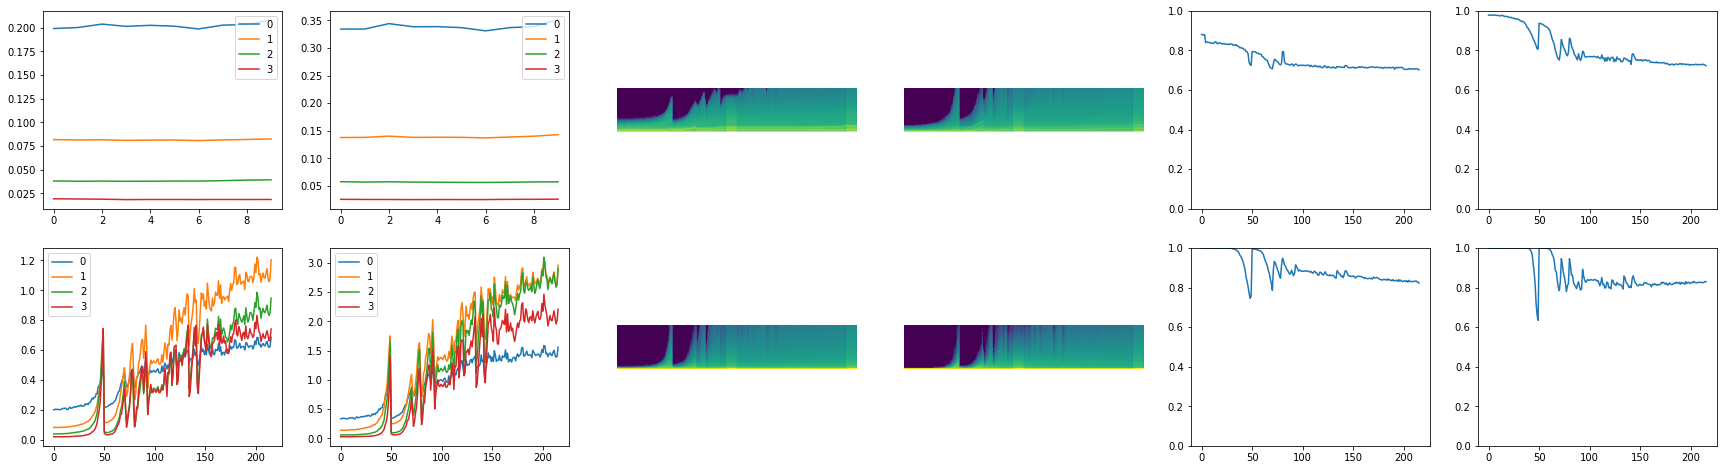

In [ ]:
def test_hook():
  loop = run_cnn_mnist(2, CNNArch(), cbs=[], hook_cls=([],[StatsHook]), repro=True)
  plot_stats (loop.hooks)

test_hook()

### Export

In [ ]:
!wget https://raw.githubusercontent.com/ketanhdoshi/ml/master/lib/nb_export.py

--2020-07-19 12:58:55--  https://raw.githubusercontent.com/ketanhdoshi/ml/master/lib/nb_export.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477 (1.4K) [text/plain]
Saving to: ‘nb_export.py’

nb_export.py        100%[===================>]   1.44K  --.-KB/s    in 0s      

2020-07-19 12:58:56 (22.4 MB/s) - ‘nb_export.py’ saved [1477/1477]



In [ ]:
from nb_export import notebook2scriptSingle
notebook2scriptSingle(gn_path + '/lib/hooks_lib.ipynb', gn_path + '/exp')

Converted gdrive/My Drive/Colab Notebooks/lib/hooks_lib.ipynb to gdrive/My Drive/Colab Notebooks/exp/nb_hooks.py


### Obsolete

In [ ]:


#----------------------------------------------------
# Forward Hook for debugging layer activation values
#----------------------------------------------------
class DebugActivationHook(Hook):
  fwd = True
  
  def __init__(self, do_print=False, dtr=None):
    self._do_print = do_print
    self.dtr = dtr
  
  def fwd_fn(self, module, inp, outp):
    if (isinstance(module, (nn.Conv2d, nn.Linear))):
      param = module.weight.mean().cpu()
    elif (isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))):
    #elif (isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, BatchNorm))):
      param = (module.mults.mean().cpu(), module.adds.mean().cpu())
    else:
      param = 'No'
    if (self._do_print):
      print('++ FWD', module, param, inp[0].mean().cpu(), outp.data.mean().cpu())

#----------------------------------------------------
# Backward Hook for debugging gradient values
#----------------------------------------------------
class DebugGradHook(Hook):
  fwd = False
  
  def __init__(self, do_print=False, dtr=None):
    self._do_print = do_print
    self.dtr = dtr
  
  def back_fn(self, module, grad_input, grad_output):
    gi, go = '--', '--'
    if (grad_input):
      gi = map(lambda x: 'None' if x is None else x.mean(), grad_input)

    if (grad_output):
      go = map(lambda x: 'None' if x is None else x.mean(), grad_output)
    
    if (self._do_print):
      print('---- BACK', module, list(gi), list(go))